# 2A.eco - Traitement automatique de la langue en Python

Aperçu de ce qu'est le traitement automatique du langage naturel ([NLP](https://fr.wikipedia.org/wiki/Traitement_automatique_du_langage_naturel)) et quelques exercices.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

Le traitement automatique des langues (ou Natural Language Processing) propose un ensemble de méthodes permettant (entre autres) : 
- d'extraire automatiquement les informations voulues de données textuelles brutes (comme apr exemple les noms propres)
- indexer des documents et permettre une recherche par mot-clés (cf. Moteurs de recherche, ou, moins ambitieux, moteurs d'auto-complétion)
- résumer automatiquement des documents,
- comparer la similarité entre plusieurs documents,
- traduction automatique,
- génération de textes automatiques,
- analyse de sentiments,
- agents conversationnels (cf. [ELIZA](https://fr.wikipedia.org/wiki/ELIZA) en 1966). Si vous voulez savoir ce qu'il se passe quand deux agents conversationnels discutent ensemble c'est [ici](https://www.youtube.com/watch?v=WnzlbyTZsQY&feature=youtu.be).  

Le traitement automatique des langues a fait ses premiers pas dans le contexte de la guerre froide, où la traduction automatique était devenu un enjeu geopolitique. En 1950, dans sont article « Computing machinery and intelligence », Alan Turing défini ce qui est appellé plus tartd, le [test de Turing](https://en.wikipedia.org/wiki/Turing_test). On dit qu'un programme passe le test de Turing s'il parvient à personnifier un humain dans une conversation écrite en temps réel, de façon suffisamment convaincante pour que l'interlocuteur humain ne puisse pas distinguer avec certitude — sur la base du seul contenu de la conversation — s'il interagit avec un programme ou avec un autre humain. 

Les progrès en traitement automatique des langues ont été beaucoup plus lents qu'initialement prévus. Cependant certains considèrent que pour la première fois en 2014, grâce aux progrès en machine learning [une machine a passé le test](http://www.theverge.com/2012/6/27/3120135/eugene-goostman-ukrainian-boy-ai-turing-test) en se faisant passer pour un enfant de 13 ans. 

L'objet de ce TD  est de présenter l'essentiel du traitement automatique des langues, selon trois approches : 

- L'approche *bag of words* : on ne tient pas compte de l'ordre des mots, ni du contexte dans lequel ils interviennent (ou alors de manière très partielle, en étudiant par exemple le mot suivant). L'idée est d'étudier la fréquence des mots d'un document et la surreprésentation des mots par rapport à un document de référence (appelé corpus). Cette approche un peu simpliste mais très efficace : on peut calculer des scores permettant par exemple de faire de classification automatique de document par thème, de comparer la similarité de deux documents. Elle est souvent utilisée en première analyse, et elle reste la référence pour l'analyse de textes mal structurés (tweets, dialogue tchat, etc.) Mot-clés : td-idf, indice de similarité cosine

- L'approche *contextuelle* : on s'intéresse non seulement aux mots et à leur fréquence, mais aussi aux mots qui suivent. Cette approche est essentielle pour désambiguiser les homonymes. Elle permet aussi d'affiner les modèles "bag-of-words". Le calcul de n-grams (bigrams pour les co-occurences de mots deux-à-deux, tri-grams pour les co-occurences trois-à-trois, etc.) constitue la méthode la plus simple pour tenir compte du contexte.

- L'approche *structurelle* : on s'intéresse à la structure des phrases, des mots (stemming, lemmatisation), aux règles syntaxiques, au sens des phrases. L'idée est d'introduire de la structure dans l'analyse du langage, à partir de règles connues et modélisées (par des expressions régulières, ou formalisation des règles syntaxiques), enrichies manuellement par des contributeurs, ou apprises par des méthodes de machine learning. Mots-clés : tokenisation des phrases et des mots, Part-Of-Speech tagging, extraction d'entité etc. Cette approche est beaucoup plus coûteuse et longue à mettre en place, mais c'est la seule capable de répondre à des besoins de traitement automatique des langues plus ambitieux tels que la traduction automatique, les agents conversationnels, et permet d'augmenter la performance des modèles de classifications de documents, de prédiction du sentiment, etc.

## Approche "bag of words"

### Récupération de données textuelles grâce à l'API Google +

### Installation 

In [2]:
import httplib2 # pip install httplib2
import json # déjà installée, sinon : pip install json
import apiclient.discovery  # pip install google-api-python-client
import bs4  # déjà ja installée, sinon : pip install bs4
import nltk  # pip install nltk --> sous Windows, il faut aller à http://www.lfd.uci.edu/~gohlke/pythonlibs/

### Récupération de la clé d'API Google + 

Pour obtenir une clé d'API google plus, il faut :
 - avoir un compte gmail (si vous n'en avez pas, c'est rapide à créer)
 - aller sur l'[interface developeurs de Google](https://code.google.com/apis/console)
 - se connecter à son compte gmail (en haut à droite)
 - à droite, sélectionner "bibliothèque", sélectionner "Google +" 
 - sélectionner "ACTIVER" (en bleu en haut)
 - à droite "Accéder à identifiants"
 - choisissez "clé API"
 - puis "aucun" et cliquer sur le bouton "Créer"
 - recopier votre clé ci-dessous

In [3]:
#remplacer par VOTRE clé
import os
import keyring
API_KEY = keyring.get_password("gapi", "ensae_teaching_cs,key")

### Connexion à l'API, et requête d'une personne ayant un compte Google + (avec activités publiques)

In [4]:
# Entrer le nom d'une personne ayant un compte google plus public
Q = "Tim O'Reilly"

# Se connecter à l'API (méthode Oauth2)
service = apiclient.discovery.build('plus', 'v1', http=httplib2.Http(), 
                                    developerKey=API_KEY)

# Récupérer les feeds
people_feed = service.people().search(query=Q).execute()

# Imprimer le json récupéré
res = json.dumps(people_feed['items'], indent=1)
print(res if len(res) < 1000 else res[:1000] + "...")

[
 {
  "kind": "plus#person",
  "etag": "\"Sh4n9u6EtD24TM0RmWv7jTXojqc/tjedXFyeIkzudZzRey5EJb8iZIk\"",
  "objectType": "person",
  "id": "107033731246200681024",
  "displayName": "Tim O'Reilly",
  "url": "https://plus.google.com/107033731246200681024",
  "image": {
   "url": "https://lh4.googleusercontent.com/-J8nmMwIhpiA/AAAAAAAAAAI/AAAAAAADdg4/68r2hyFUgzI/photo.jpg?sz=50"
  }
 },
 {
  "kind": "plus#person",
  "etag": "\"Sh4n9u6EtD24TM0RmWv7jTXojqc/ofg-30rIv-rKw7XTBBnDA1i3I_Y\"",
  "objectType": "person",
  "id": "110160587587635791009",
  "displayName": "TIM O'REILLY",
  "url": "https://plus.google.com/110160587587635791009",
  "image": {
   "url": "https://lh4.googleusercontent.com/-gWq9vr_JEnc/AAAAAAAAAAI/AAAAAAAAADI/zwCXKP4QeiU/photo.jpg?sz=50"
  }
 },
 {
  "kind": "plus#person",
  "etag": "\"Sh4n9u6EtD24TM0RmWv7jTXojqc/DVTuV3GDJ0h4UlM5bybS_d26Fdo\"",
  "objectType": "person",
  "id": "106492472890341598734",
  "displayName": "Tim O'Reilly",
  "url": "https://plus.google.com/10649

In [5]:
# Parce que l'on travaille sur un Notebook il est possible d'afficher facilement les images correspondantes
# l'identifiant unique d'avatar google plus et le nom

from IPython.core.display import HTML

html = []

for p in people_feed['items']:
    html += ['<p><img src="{}" /> {}: {}</p>'.format(p['image']['url'], p['id'], p['displayName'])]

HTML(''.join(html[:5]))

### Requete sur l'activité de la personne sélectionnée

In [6]:
USER_ID = '107033731246200681024'

activity_feed = service.activities().list(
  userId=USER_ID,
  collection='public',
  maxResults='100' # Max allowed per API
).execute()

res = json.dumps(activity_feed, indent=1)
print(res if len(res) < 1000 else res[:1000] + "...")

{
 "kind": "plus#activityFeed",
 "etag": "\"Sh4n9u6EtD24TM0RmWv7jTXojqc/UVhLnzZeFbRMD00k0VRD5tkC6es\"",
 "nextPageToken": "ADSJ_i32R0IpxThTClWgVQ71un8FkJDHG8Pl4hLCvWIbyb6T65r6coxSlWk1svDgsrzxTQ3JHFV1CGnbjFCSaY14sttcvnb1QgiHBgXRtn3A8GjJjin7",
 "title": "Google+ List of Activities for Collection PUBLIC",
 "updated": "2017-09-13T15:59:45.234Z",
 "items": [
  {
   "kind": "plus#activity",
   "etag": "\"Sh4n9u6EtD24TM0RmWv7jTXojqc/Dlr_44FOo97cNjKbX7ZHrVWgen4\"",
   "title": "It looks like #@CTRLLabsCo has made a real breakthrough. This is one of the advances that will take ...",
   "published": "2017-09-13T15:59:31.577Z",
   "updated": "2017-09-13T15:59:45.234Z",
   "id": "z123e5zb4zbmcxf5004chl3pvxfbszirt5o",
   "url": "https://plus.google.com/+TimOReilly/posts/TpYYyGh7pr1",
   "actor": {
    "id": "107033731246200681024",
    "displayName": "Tim O'Reilly",
    "url": "https://plus.google.com/107033731246200681024",
    "image": {
     "url": "https://lh4.googleusercontent.com/-J8nmMwIhpiA

### Nettoyage des données textuelles avec BS4 

In [7]:
from bs4 import BeautifulSoup

def cleanHtml(html):
    if html == "": return ""
    return BeautifulSoup(html, 'html.parser').get_text()

try:
    print(activity_feed['items'][0]['object']['content'])
    print("\n")
    print(cleanHtml(activity_feed['items'][0]['object']['content']))
except Exception as e:
    print(e)

It looks like #@CTRLLabsCo has made a real breakthrough. This is one of the advances that will take us beyond the smartphone. If you&#39;ve done any playing around with augmented reality, you realize that control and interaction is one of the key blocks to widespread adoption. Brain-computer interfaces are a key combinatorial innovation that will enable a completely different UI paradigm for interacting with devices and ambient computing. 


It looks like #@CTRLLabsCo has made a real breakthrough. This is one of the advances that will take us beyond the smartphone. If you've done any playing around with augmented reality, you realize that control and interaction is one of the key blocks to widespread adoption. Brain-computer interfaces are a key combinatorial innovation that will enable a completely different UI paradigm for interacting with devices and ambient computing. 


### Récupération des données et stockage

Créer un dossier "ressources_googleplus" dans votre répertoire courant (%pwd pour le connaitre)

In [8]:
%pwd

'C:\\xavierdupre\\__home_\\GitHub\\ensae_teaching_cs\\_doc\\notebooks\\td2a_eco'

In [9]:
import json
import apiclient.discovery

MAX_RESULTS = 200 # limite fixée à 100 résultats par requete => on va itérer sur une boucle pour en avoir 200

activity_feed = service.activities().list(
  userId=USER_ID,
  collection='public',
  maxResults='100' 
)

activity_results = []

while activity_feed != None and len(activity_results) < MAX_RESULTS:
    activities = activity_feed.execute()
    
    if 'items' in activities:
        for activity in activities['items']:
            if activity['object']['objectType'] == 'note' and activity['object']['content'] != '':
                activity['title'] = cleanHtml(activity['title'])
                activity['object']['content'] = cleanHtml(activity['object']['content'])
                activity_results += [activity]
                
    # list_next permet de passer à la requete suivante
    activity_feed = service.activities().list_next(activity_feed, activities)

# on écrit le résultat dans un fichier json
import os
if not os.path.exists("ressources_googleplus"):
    os.mkdir("ressources_googleplus")
f = open('./ressources_googleplus/' + USER_ID + '.json', 'w')
f.write(json.dumps(activity_results, indent=1))
f.close()

print(str(len(activity_results)), "activités écrites dans", f.name)

273 activités écrites dans ./ressources_googleplus/107033731246200681024.json


## Analyse des données textuelles - TD-IDF, similarité cosine et n-grams

Le calcul [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (term frequency–inverse document frequency) permet de calculer un score de proximité entre un terme de recherche et un document (c'est ce que font les moteurs de recherche). La partie tf calcule une fonction croissante de la fréquence du terme de recherche dans le document à l'étude, la partie idf calcule une fonction inversement proportionnelle à la fréquence du terme dans l'ensemble des documents (ou corpus). Le score total, obtenu en multipliant les deux composantes, permet ainsi de donner un score d'autant plus élevé que le terme est surréprésenté dans un document (par rapport à l'ensemble des documents). Il existe plusieurs fonctions, qui pénalisent plus ou moins les documents longs, ou qui sont plus ou moins smooth.

### Exemple sur un petit corpus de 3 documents

In [10]:
corpus = { 
 'a' : "Mr. Green killed Colonel Mustard in the study with the candlestick. \
Mr. Green is not a very nice fellow.",
 'b' : "Professor Plum has a green plant in his study.",
 'c' : "Miss Scarlett watered Professor Plum's green plant while he was away \
from his office last week."
}
terms = {
 'a' : [ i.lower() for i in corpus['a'].split() ],
 'b' : [ i.lower() for i in corpus['b'].split() ],
 'c' : [ i.lower() for i in corpus['c'].split() ]
 }

In [11]:
from math import log

QUERY_TERMS = ['mr.', 'green']

def tf(term, doc, normalize=True):
    doc = doc.lower().split()
    if normalize:
        return doc.count(term.lower()) / float(len(doc))
    else:
        return doc.count(term.lower()) / 1.0


def idf(term, corpus):
    num_texts_with_term = len([True for text in corpus if term.lower() \
                              in text.lower().split()])
    try:
        return 1.0 + log(float(len(corpus)) / num_texts_with_term)
    except ZeroDivisionError:
        return 1.0
    
def tf_idf(term, doc, corpus):
    return tf(term, doc) * idf(term, corpus)

In [12]:
for (k, v) in sorted(corpus.items()):
    print(k, ':', v)
print('\n')

query_scores = {'a': 0, 'b': 0, 'c': 0}
for term in [t.lower() for t in QUERY_TERMS]:
    for doc in sorted(corpus):
        print('TF({}): {}'.format(doc, term), tf(term, corpus[doc]))
    print('IDF: {}'.format(term, ), idf(term, corpus.values()))
    print('\n')
    for doc in sorted(corpus):
        score = tf_idf(term, corpus[doc], corpus.values())
        print('TF-IDF({}): {}'.format(doc, term), score)
        query_scores[doc] += score
    print('\n')

print("Score TF-IDF total pour le terme '{}'".format(' '.join(QUERY_TERMS), ))
for (doc, score) in sorted(query_scores.items()):
    print(doc, score)

a : Mr. Green killed Colonel Mustard in the study with the candlestick. Mr. Green is not a very nice fellow.
b : Professor Plum has a green plant in his study.
c : Miss Scarlett watered Professor Plum's green plant while he was away from his office last week.


TF(a): mr. 0.10526315789473684
TF(b): mr. 0.0
TF(c): mr. 0.0
IDF: mr. 2.09861228866811


TF-IDF(a): mr. 0.22090655670190631
TF-IDF(b): mr. 0.0
TF-IDF(c): mr. 0.0


TF(a): green 0.10526315789473684
TF(b): green 0.1111111111111111
TF(c): green 0.0625
IDF: green 1.0


TF-IDF(a): green 0.10526315789473684
TF-IDF(b): green 0.1111111111111111
TF-IDF(c): green 0.0625


Score TF-IDF total pour le terme 'mr. green'
a 0.3261697145966431
b 0.1111111111111111
c 0.0625


Le score td-idf pour le terme "Mr. Green" est le plus élevé pour le document a. 

### Exercice 1

Quel document est le plus proche du terme "green plant ? Calculer les scores TF-IDF pour le terme "green plan". Cela correspond-il à vos attentes ? Que se passe-t-il si vous inversez les termes "green" et "plant" ? Que se passe-t-il avec "green" seul ? 

### Introduction à NLTK

In [13]:
import nltk

# nltk donne accès a des methodes, mais aussi à des données, qui faut télécharge grâce à la commande .download()
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xavie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
from pprint import pprint

In [15]:
len(activity_results)

273

In [16]:
if len(activity_results) > 0:
    pprint(activity_results[0])

{'access': {'description': 'Public',
            'items': [{'type': 'public'}],
            'kind': 'plus#acl'},
 'actor': {'displayName': "Tim O'Reilly",
           'id': '107033731246200681024',
           'image': {'url': 'https://lh4.googleusercontent.com/-J8nmMwIhpiA/AAAAAAAAAAI/AAAAAAADdg4/68r2hyFUgzI/photo.jpg?sz=50'},
           'url': 'https://plus.google.com/107033731246200681024',
           'verification': {'adHocVerified': 'PASSED'}},
 'etag': '"Sh4n9u6EtD24TM0RmWv7jTXojqc/Dlr_44FOo97cNjKbX7ZHrVWgen4"',
 'id': 'z123e5zb4zbmcxf5004chl3pvxfbszirt5o',
 'kind': 'plus#activity',
 'object': {'actor': {'verification': {'adHocVerified': 'PASSED'}},
            'attachments': [{'content': 'This startup lets you control '
                                        'machines with your mind—no implants '
                                        'required.',
                             'displayName': "The Brain-Machine Interface Isn't "
                                            'Sci-Fi 

In [17]:
if len(activity_results) > 0:
    pprint(activity_results[0]['object']['content'])

('It looks like #@CTRLLabsCo has made a real breakthrough. This is one of the '
 "advances that will take us beyond the smartphone. If you've done any playing "
 'around with augmented reality, you realize that control and interaction is '
 'one of the key blocks to widespread adoption. Brain-computer interfaces are '
 'a key combinatorial innovation that will enable a completely different UI '
 'paradigm for interacting with devices and ambient computing. ')


In [18]:
all_content = " ".join([ a['object']['content'] for a in activity_results ])

print("Nombre de caractères : ",len(all_content))
print('\n')

#Tokenisation naïve sur les espaces entre les mots => on obtient une liste de mots
tokens = all_content.split()

#On transforme cette liste en objet nltk "Text" (objet chaine de caractère qui conserve la notion de tokens, et qui 
#comprend  un certain nombre de méthodes utiles pour explorer les données.
text = nltk.Text(tokens)

#Comme par exemple "concordance" : montre les occurences d'un mot dans son contexte
print("Exemples d'occurences du terme 'open' :")
text.concordance("open")
print('\n')


# Analyse de la fréquence des termes d'intérêt 
fdist = text.vocab()

print("Co-occurences fréquentes :")
text.collocations()
print('\n')
print("Nombre de mots :", len(tokens))
print('\n')
print("Nombre de mots uniques :",len(fdist.keys()))
print('\n')
print("Nombre de mots uniques v2 :",len(set(tokens)))


print("Nombre d'occurences du terme 'open' :",fdist["open"])
print("Nombre d'occurences du terme 'source' :", fdist["source"])
print("Nombre d'occurences du terme 'web' :", fdist["web"])
print("Nombre d'occurences du terme 'API' :",fdist["API"])
print('\n')

#100 tokens les plus fréquents
top100_items = sorted(fdist.items(),key=lambda x: x[1],reverse=True)[:100]
#sans les fréquences
top100 = [t[0] for t in top100_items]
print("Top 100 :", top100)
print('\n')

#sans les termes trop frequents ("stopwords")
top100_without_stopwords = [w for w in top100 if w.lower() \
                         not in nltk.corpus.stopwords.words('english')]
print("Top 100 sans les mots fréquents :", top100_without_stopwords)
print('\n')

long_words_not_urls = [w for w in fdist.keys() if len(w) > 15 and not w.startswith("http")]
print("Longs mots sans les urls :", long_words_not_urls)
print('\n')

# Nombre d'urls
print("Nombre d'urls :", len([w for w in fdist.keys() if w.startswith("http")]))
print('\n')

# Enumerate the frequency distribution
for rank, word in enumerate(sorted(fdist.items(),key=lambda x: x[1],reverse=True)): 
    print(rank, word)
    if rank > 75:
        print("....")
        break

Nombre de caractères :  103138


Exemples d'occurences du terme 'open' :
Displaying 13 of 13 matches:
, and how at least one team is using open source to let others see inside the 
ear that computational biologist and open science advocate (UC Berkeley profes
: magazine slogan say, "If you can't open it, you don't own it." Predictive po
 I'm proud to be a signatory to this open letter calling for this key policy i
st, I've focused a lot on areas like open source software and the implications
opic at greater length in my article Open Data and Algorithmic Regulation: htt
cessful participatory projects, from open source software to wikis to social m
ere isn't one (except that it's only open to US students - sorry. If anyone ha
new contract that conformed with the open data mandate. If it were consistent 
If it were consistent with the Obama open data guidance, that RFP would requir
ut of step with the administration’s open data policy.The founder of Hipcamp, 
is is a really important piec

In [19]:
fdist = text.vocab()

In [20]:
%matplotlib inline

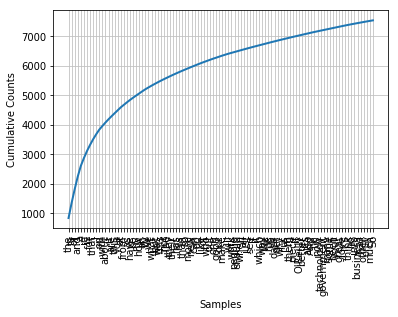

In [21]:
fdist.plot(100,cumulative=True)

### Exercice 2

Les notes de Tim O'Reilly parlent-elles des élections américaines ? Avec quelle fréquence ? Essayer "Hillary","Trump", "vote", d'autres idées ? 

Quelle distribution des termes sans les stopwords ? Vérifie-t-on la loi [Zipf](https://en.wikipedia.org/wiki/Zipf%27s_law) selon laquelle la fréquence des mots est inversement proportionnelle à son rang  (le 10 ème mot est 10 fois moins présent que le premier) ? Et si l'on laisse les "stopwords" ?

Proposer un indice du calcul de la diversité du vocabulaire de Tim O'Reilly. 

### Requeter les données Google + avec TF-IDF

Le code ci-après permet d'indexer des textes en fonction d'un score de pertinence pour une requête donnée. En d'autres termes, vous avez un petit moteur de recherche :)

In [22]:
import json
import nltk

path = 'ressources_googleplus/107033731246200681024.json'
text_data = json.loads(open(path).read())

QUERY_TERMS = ['open','data']

activities = [activity['object']['content'].lower().split() \
              for activity in text_data \
                if activity['object']['content'] != ""]

# Le package TextCollection contient un module tf-idf
tc = nltk.TextCollection(activities)

relevant_activities = []

for idx in range(len(activities)):
    score = 0
    for term in [t.lower() for t in QUERY_TERMS]:
        score += tc.tf_idf(term, activities[idx])
    if score > 0:
        relevant_activities.append({'score': score, 'title': text_data[idx]['title'],
                              'url': text_data[idx]['url']})

# Tri par score et présentation des résultats 

relevant_activities = sorted(relevant_activities, 
                             key=lambda p: p['score'], reverse=True)
c=0
for activity in relevant_activities:
    if c < 6:
        print(activity['title'])
        print('\tLink: {}'.format(activity['url']))
        print('\tScore: {}'.format(activity['score']))
        c+=1

This is a really important piece about open data and platforms.
	Link: https://plus.google.com/+TimOReilly/posts/fo9uxWTctHb
	Score: 0.5498599632119789
I love new sources of trend data about technology adoption. We've used variations of this for years ...
	Link: https://plus.google.com/+TimOReilly/posts/FetXVRJeJFv
	Score: 0.17368671875174563
If you love Hamilton, as I do, and you're interested in data visualization, you'll find this fascinating...
	Link: https://plus.google.com/+TimOReilly/posts/NNsiSo8K7B7
	Score: 0.16687547487912816
Data can play a great role in advancing sustainability. I'm quoted in this short video from Planet Labs...
	Link: https://plus.google.com/+TimOReilly/posts/45KX41Q2LN4
	Score: 0.15760461516362104
Mark Cuban's tweet about data science in the NBA, featuring the image of his screen and an O'Reilly ...
	Link: https://plus.google.com/+TimOReilly/posts/2hCQhfTaX5g
	Score: 0.14184415364725894
An excellent demonstration of why Open Access lowers the barriers to 

### Exercice 3

- Tester d'autres termes de recherche (easy). Quelles limites voyez-vous ? 
- Tester d'autres fonctions [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (faites par vous, en vous inspirant du code " Exemple sur un petit corpus de 3 documents")

### Trouver des documents proches avec la similarité cosine

In [23]:
import json
import nltk


path = 'ressources_googleplus/107033731246200681024.json'
data = json.loads(open(path).read())

# Sélection des textes qui ont plus de 1000 mots
data = [ post for post in json.loads(open(path).read()) \
         if len(post['object']['content']) > 1000 ]

all_posts = [post['object']['content'].lower().split() 
             for post in data ]

tc = nltk.TextCollection(all_posts)

# Calcul d'une matrice terme de recherche x document
# Renvoie un score tf-idf pour le terme dans le document

td_matrix = {}
for idx in range(len(all_posts)):
    post = all_posts[idx]
    fdist = nltk.FreqDist(post)

    doc_title = data[idx]['title']
    url = data[idx]['url']
    td_matrix[(doc_title, url)] = {}

    for term in fdist.keys():
        td_matrix[(doc_title, url)][term] = tc.tf_idf(term, post)

In [24]:
distances = {}

for (title1, url1) in td_matrix.keys():
    
    distances[(title1, url1)] = {}
    (min_dist, most_similar) = (1.0, ('', ''))
    
    for (title2, url2) in td_matrix.keys():
        
        #copie des valeurs (un dictionnaire étant mutable)
        terms1 = td_matrix[(title1, url1)].copy()
        terms2 = td_matrix[(title2, url2)].copy()
        
        #on complete les gaps pour avoir des vecteurs de même longueur
        for term1 in terms1:
            if term1 not in terms2:
                terms2[term1] = 0

        for term2 in terms2:
            if term2 not in terms1:
                terms1[term2] = 0
                
        #on créé des vecteurs de score pour l'ensemble des terms de chaque document
        v1 = [score for (term, score) in sorted(terms1.items())]
        v2 = [score for (term, score) in sorted(terms2.items())]

        #calcul des similarité entre documents : distance cosine entre les deux vecteurs de scores tf-idf
        distances[(title1, url1)][(title2, url2)] = \
            nltk.cluster.util.cosine_distance(v1, v2)

In [25]:
import pandas as p
df_dist=p.DataFrame(distances)
df_dist.iloc[:5,:5]

,,"""Surely Democrats and Republicans could agree to cut billions from a failed program like this!"" you ...",Absolutely fascinating exploration of the microbiome of a city.\n\nFor those who don't know what the microbiome...,Amazing story about digital transformation http://www.codeforamerica.org/blog/2015/11/30/a-new-approach...,Can We Use Data to Make Better Regulations?\n\nEvgeny Morozov either misunderstands or misrepresents the...,"From an article about Walmart, their move to pay more, and the lessons for the broader economy: http..."
,,https://plus.google.com/+TimOReilly/posts/1Lcxb3b8VPH,https://plus.google.com/+TimOReilly/posts/7EaHeYc1BiB,https://plus.google.com/+TimOReilly/posts/BRmKh2ycaPe,https://plus.google.com/+TimOReilly/posts/gboAUahQwuZ,https://plus.google.com/+TimOReilly/posts/bqErtyYp6co
"""Surely Democrats and Republicans could agree to cut billions from a failed program like this!"" you ...",https://plus.google.com/+TimOReilly/posts/1Lcxb3b8VPH,0.000000,0.983031,0.965728,0.897357,9.415217e-01
Absolutely fascinating exploration of the microbiome of a city.\n\nFor those who don't know what the microbiome...,https://plus.google.com/+TimOReilly/posts/7EaHeYc1BiB,0.983031,0.000000,0.973205,0.960363,9.699011e-01
Amazing story about digital transformation http://www.codeforamerica.org/blog/2015/11/30/a-new-approach...,https://plus.google.com/+TimOReilly/posts/BRmKh2ycaPe,0.965728,0.973205,0.000000,0.967001,9.862850e-01
Can We Use Data to Make Better Regulations?\n\nEvgeny Morozov either misunderstands or misrepresents the...,https://plus.google.com/+TimOReilly/posts/gboAUahQwuZ,0.897357,0.960363,0.967001,0.000000,9.551053e-01
"From an article about Walmart, their move to pay more, and the lessons for the broader economy: http...",https://plus.google.com/+TimOReilly/posts/bqErtyYp6co,0.941522,0.969901,0.986285,0.955105,-2.220446e-16


### Exercice 4 

- Quel document est le plus proche de celui-ci: https://plus.google.com/+TimOReilly/posts/7EaHeYc1BiB ?
- Représenter la matrice de distance à l'aide d'une [heatmap](http://seaborn.pydata.org/examples/heatmap_annotation.html).
- Que donne un [clustering hiérarchique](http://seaborn.pydata.org/generated/seaborn.clustermap.html#seaborn.clustermap) ?

# Approche contextuelle

Les approches bag-of-words, bien que simplistes, permettent de créer d'indexer et de comparer des documents. La prise en compte des suites de 2, 3 ou plus mots serait un moyen d'affiner de tels modèles. Cela permet aussi de mieux comprendre le sens des homonymes, et des phrases (d'une manière générale, la sémantique).

nltk offre des methodes pour tenir compte du contexte : pour ce faire, nous calculons les n-grams, c'est-à-dire l'ensemble des co-occurrences successives de mots deux-à-deux (bigrams), trois-à-trois (tri-grams), etc. 

En général, on se contente de bi-grams, au mieux de tri-grams : 
- les modèles de classification, analyse du sentiment, comparaison de documents, etc. qui comparent des n-grams avec n trop grands sont rapidement confrontés au problème de données sparse, cela réduit la capacité prédictive des modèles ; 
- les performances décroissent très rapidement en fonction de n, et les coûts de stockage des données augmentent rapidement (environ n fois plus élevé que la base de donnée initiale).

### Exemple avec un petit corpus

In [26]:
import nltk

sentence = "Mr. Green killed Colonel Mustard in the study with the " + \
           "candlestick. Mr. Green is not a very nice fellow."

print(nltk.ngrams(sentence.split(), 2))
      
txt = nltk.Text(sentence.split())

txt.collocations()

<generator object ngrams at 0x000001ECB34F46D0>
Mr. Green


### Analyse des co-occurences dans les données textuelles issues de Google +

In [27]:
import json
import nltk

path = 'ressources_googleplus/107033731246200681024.json'
data = json.loads(open(path).read())

# Nombre de co-occurrences à trouver

N = 25

all_tokens = [token for activity in data for token in \
              activity['object']['content'].lower().split()]

finder = nltk.BigramCollocationFinder.from_words(all_tokens)
finder.apply_freq_filter(2)

#filtre des mots trop fréquents

finder.apply_word_filter(lambda w: w in nltk.corpus.stopwords.words('english'))

bigram_measures = nltk.collocations.BigramAssocMeasures()

collocations = finder.nbest(bigram_measures.jaccard, N)

for collocation in collocations:
    c = ' '.join(collocation)
    print(c)

bottom, “copyright
brett goldstein
cabo pulmo
nbc press:here
nick hanauer
press:here tv
wood fired
yuval noah
silicon valley
+jennifer pahlka
barre historical
computational biologist
mikey dickerson
saul griffith
bay mini
child welfare
credit card
east bay
on-demand economy,
white house
drm-free ebooks
humble bundle
inca trail
italian granite
private sector


### Exercice 5 

- tester d'autres métriques que la distance de jaccard et comparer les résultats
- extraire les tri-grams